In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cst
from scipy.optimize import fsolve
from scipy import linalg
from numpy import sin, cos, sqrt, pi
import copy

In [2]:
# Constants
e0 = 8.854e-12 #F / m
kB = 1.380649e-23 # Boltzmann const
hbar = 1.054571817e-34
h = 6.62607015e-34
q = 1.602176634e-19
phi0 = h / 2 / q

In [19]:
class UnitCellLayout:
    def __init__(self, cell_height, cell_width,
                 jj_width, jj_height, I0_ratio, 
                 bottom_margin, relative_permitivity, 
                 chip_separation, jj_seperation, J0):
        self.cell_height = cell_height
        self.cell_width = cell_width
        self.jj_width = jj_width
        self.jj_height = jj_height
        self.I0_ratio = I0_ratio
        self.bottom_margin = bottom_margin
        self.relative_permitivity = relative_permitivity
        self.chip_separation = chip_separation #nm
        self.jj_seperation = jj_seperation
        self.J0 = J0

        self.cell_area = 0

    def draw_layout(self, ax, x_offset=0, alt=0):
        # Draw cell frame
        cell_frame_left = plt.Rectangle((x_offset - self.cell_width/2, -self.cell_height/2), self.cell_width / 2 - 1.5 * self.jj_width - 2 * self.bottom_margin, self.cell_height, linewidth=0.5, edgecolor='black', facecolor='grey')
        ax.add_patch(cell_frame_left)

        cell_frame_right = plt.Rectangle((x_offset +  1.5 * self.jj_width + 2 * self.bottom_margin, -self.cell_height/2), self.cell_width / 2 - 1.5 * self.jj_width - 2 * self.bottom_margin, self.cell_height, linewidth=0.5, edgecolor='black', facecolor='grey')
        ax.add_patch(cell_frame_right)

        large_junction_frame = plt.Rectangle((x_offset - 1.5 * self.jj_width - 2 * self.bottom_margin, (-1)**alt * (self.cell_height / 2 - self.jj_height)), 3 * self.jj_width + 4 * self.bottom_margin, (-1)**alt * self.jj_height, linewidth=0.5, edgecolor='black', facecolor='grey')
        ax.add_patch(large_junction_frame)

        small_junction_frame = plt.Rectangle((x_offset - 1.5 * self.jj_width - 2 * self.bottom_margin, (-1)**alt * (- self.cell_height / 2)), 3 * self.jj_width + 4 * self.bottom_margin, (-1)**alt * self.jj_height * self.I0_ratio, linewidth=0.5, edgecolor='black', facecolor='grey')
        ax.add_patch(small_junction_frame)

        # Draw small junction on bottom 
        small_junc = plt.Rectangle((x_offset - self.jj_width / 2, (-1)**alt * - self.cell_height / 2), self.jj_width, (-1)**alt * self.jj_height * self.I0_ratio, linewidth=0.5, edgecolor='black', facecolor='orange')
        ax.add_patch(small_junc)

        # Draw three large junctions on top 
        for i in range(-1, 2):
            large_junc = plt.Rectangle((x_offset - self.jj_width / 2 + (self.jj_width + self.bottom_margin) * i, (-1)**alt * (self.cell_height / 2 - self.jj_height)), self.jj_width, (-1)**alt * self.jj_height, linewidth=0.5, edgecolor='black', facecolor='blue')
            ax.add_patch(large_junc)


        for frame in [cell_frame_left, cell_frame_right, large_junction_frame, small_junction_frame]:
            self.cell_area += abs(frame.get_width()*frame.get_height())

        return ax

    def draw_row(self, N):
        fig, ax = plt.subplots(figsize=(10,5))
        
        for i in range(N):
            x_offset = i * self.cell_width
            self.draw_layout(ax, x_offset, alt=i%2)

        plt.xlim(-self.cell_width/2 * 1.1, self.cell_width * N)
        plt.ylim(-self.cell_height/2 * 1.1, self.cell_height/2 * 1.1)
        # plt.gca().set_aspect('fixed', adjustable='box')
        plt.xlabel('Width (um)')
        plt.ylabel('Height (um)')
        plt.title(f'Device Layout ({N} Cells)')
        plt.grid(True)
        plt.show()

    def calculate_Cg(self):
        return e0 * self.relative_permitivity * self.cell_area*1e-12 / (self.chip_separation*1e-9)
    
    def calculate_Cj(self):
        return e0 * self.relative_permitivity * (self.jj_height*1e-6) * (self.jj_width*1e-6) / (self.jj_seperation*1e-9) * (1/3 + self.I0_ratio)
    
    def calculate_I0(self):
        return self.J0 * self.jj_height * self.jj_width


In [20]:
class ReverseKerrTWPAGeometry:
    def __init__(self, chip_height, chip_width, margin, launchpads, 
                 line_gap, line_width, cell_width, delay_length, 
                 num_paths):
        # Substrate parameters
        self.chip_height = chip_height
        self.chip_width = chip_width
        self.margin = margin

        # Launchpads is a list of coordinates
        self.launchpads = launchpads

        self.line_gap = line_gap
        self.line_width = line_width
        self.cell_width = cell_width

        self.turn_radius = line_gap/2
        self.delay_length = delay_length
        self.num_paths = num_paths

        self.total_devices = 0
        # Additional attributes for visualization
        self.fig, self.ax = plt.subplots(figsize=(30,30))

    def plot_geometry(self):
        # Plot chip boundary
        chip_boundary = plt.Rectangle((0, 0), self.chip_height, self.chip_width, linewidth=1, edgecolor='black',
                                     facecolor='none')
        self.ax.add_patch(chip_boundary)

        # Plot device region
        device_region = plt.Rectangle((self.margin, self.margin),
                                      self.chip_width - 2 * self.margin, self.chip_width - 2 * self.margin,
                                      linewidth=0.5, edgecolor='blue', facecolor='none')
        self.ax.add_patch(device_region)

        # Plot launchpads
        self.draw_launchpad(self.launchpads[0])
        self.draw_launchpad(self.launchpads[1], flip=True)

        # Plot waveguide
        self.plot_devices()

        # Customize as needed
        self.ax.set_xlim(-1, self.chip_height)
        self.ax.set_ylim(-1, self.chip_width)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

    def draw_launchpad(self, launchpad, flip=False):
        # Customize launchpad shape and size
        if flip:
            launchpad_shape = plt.Polygon([(launchpad[0] - self.margin, launchpad[1]),
                                           (launchpad[0], launchpad[1] + self.margin),
                                           (launchpad[0], launchpad[1] - self.margin)],
                                          edgecolor='green', facecolor='none', linewidth=1)
        else:
            launchpad_shape = plt.Polygon([(launchpad[0], launchpad[1] - self.margin),
                                           (launchpad[0] + self.margin, launchpad[1]),
                                           (launchpad[0], launchpad[1] + self.margin)],
                                          edgecolor='green', facecolor='none', linewidth=1)
        self.ax.add_patch(launchpad_shape)

    def plot_devices(self):
        # Plot the waveguide in a snaking fashion
        waveguide_start = np.array([self.launchpads[0][0] + self.margin, self.launchpads[0][1]])
        waveguide_end = np.array([self.launchpads[1][0] - self.margin, self.launchpads[1][1]])

        N_delay_cells_left = int(self.delay_length / self.cell_width)
        for delay_cell in range(N_delay_cells_left):
            #Left Delay
            x_pos = waveguide_start[0] + self.cell_width * delay_cell
            y_pos = waveguide_start[1]
            self.draw_waveguide_unit_cell(self.cell_width, x_pos, y_pos)

        waveguide_start = x_pos + self.cell_width, y_pos

        # Function to add linear and curved paths with embedded devices
        def add_paths(start, paths):
            for path in paths:
                waveguide_start = self.plot_curved_path(start, path[0], reverse=path[1], qrt=path[2])
                start = self.plot_linear_path(waveguide_start, path[3], path[4])

            N_delay_cells_right = int((waveguide_end[0]-start[0]) / self.cell_width)
            for delay_cell in range(N_delay_cells_right):
                #Right Delay
                x_pos = waveguide_end[0] - self.cell_width * delay_cell
                y_pos = waveguide_end[1]
                self.draw_waveguide_unit_cell(self.cell_width, x_pos, y_pos)

        def generate_paths(N):
            paths = [(np.pi/2, False, True, self.chip_height/2-self.margin-2*self.turn_radius-self.cell_width, np.pi/2)]

            # Add repeated entries
            for _ in range(N):  # Adjust the range based on the number of repeated entries
               paths.append((np.pi, True if _%2 else False, False, self.chip_height-2*self.margin-2*self.turn_radius, np.pi/2 if _%2 else -np.pi/2))

            # Add unique entries
            
            # Half-length line
            paths.append(
                ((np.pi, True, False, self.chip_height/2-self.margin-2*self.turn_radius, np.pi/2) if N%2 
                else (np.pi, False, False, self.chip_height/2-self.margin-2*self.turn_radius, -np.pi/2))
            )

            #Qrt curve
            paths.append(
                (np.pi/2, True, True, 0, np.pi/2)
            )

            return paths

        paths = generate_paths(self.num_paths)#int((self.chip_width - 2*self.margin - 2*self.delay_length) / (self.line_width+self.line_gap)))
        # Add the paths with embedded devices
        add_paths(waveguide_start, paths)


    def plot_curved_path(self, start, max_angle, reverse=False, qrt=False):
        N_curve_cells = int(self.turn_radius * max_angle / self.cell_width)
        curved_paths = np.linspace(0, max_angle, N_curve_cells)

        for angle in curved_paths:
            x_pos, y_pos = self.calculate_position(start, angle, reverse, qrt)
            self.draw_waveguide_unit_cell(self.cell_width, x_pos, y_pos, reverse, angle)

        return x_pos, y_pos


    def plot_linear_path(self, start, length, angle):
        N_lin_cells = int(length / self.cell_width)

        x_pos = start[0]
        y_pos = start[1]

        for lin_cell in range(N_lin_cells):
            x_pos = start[0]
            y_pos = start[1] + self.cell_width * (2 * angle / np.pi) * lin_cell
            self.tot_devices+=1
            self.draw_waveguide_unit_cell(self.cell_width, x_pos, y_pos, angle)

        return x_pos, y_pos
    
    def calculate_position(self, start, angle, reverse, qrt):
        if reverse:
            x_pos = start[0] - (np.cos(angle) - 1) * self.turn_radius
            y_pos = start[1] - np.sin(angle) * self.turn_radius
        elif qrt:
            x_pos = start[0] + np.sin(angle) * self.turn_radius
            y_pos = start[1] - (np.cos(angle) - 1) * self.turn_radius
        else:
            x_pos = start[0] - (np.cos(angle) - 1) * self.turn_radius
            y_pos = start[1] + np.sin(angle) * self.turn_radius

        return x_pos, y_pos

    def draw_waveguide_unit_cell(self, length, x_pos, y_pos, reverse=False, angle=0):
        # Draw a unit cell of the waveguide
        unit_cell = plt.Rectangle((x_pos, y_pos), length, self.line_width, angle=np.degrees(angle if reverse else -angle),
                                  linewidth=0.2, edgecolor='white', facecolor='black')
        self.ax.add_patch(unit_cell)
        # self.total_devices += 1

In [21]:
class SNAIL:
    def __init__(self, Cg, I0, N):
        # Params: 
        #   Cg - Capacitance to ground per SNAIL
        #   L - Inductance per SNAIL
        #   N - Number of array junctions
        
        self.Cg = Cg
        self.I0 = I0
        self.N = N

        self.Ec = q**2 / 2 / self.Cg

    def get_freq(self):
        self.omega = 1 / sqrt(self.get_inductance() * self.Cg)
        return self.omega
    
    def get_inductance(self):
        return phi0 / 2 / pi / self.I0 / self.alpha()
        #return 1 / self.I0 / self.alpha(phi_e, r)
    
    def current(self,phi_min):
        return self.r * np.sin(phi_min) + np.sin((phi_min-self.phi_e) / self.N)

    def set_phi_min(self):
        self.phi_min = fsolve(self.current, 0)[0]
        return self.phi_min

    def alpha(self):
        return self.r*cos(self.phi_min) + cos((self.phi_min - self.phi_e) / self.N) / self.N
    
    def beta(self):
        return (self.r*sin(self.phi_min) + sin((self.phi_min - self.phi_e) / self.N) / self.N**2) / 2
    
    def gamma(self):
        return (self.r*cos(self.phi_min) + cos((self.phi_min - self.phi_e) / self.N) / self.N**3) / 6
    
    def c2(self):
        return self.alpha() / 2
    
    def c3(self):
        return -self.beta() / 3
    
    def c4(self):
        return -self.gamma() / 4

    def g3(self):
        return self.beta() / 3 / self.alpha() * sqrt(self.Ec*hbar*self.get_freq()) / hbar

    def g4(self):
        return self.gamma() / 2 / self.alpha() * self.Ec / hbar
    
    def plot_heatmap(self, phis, rs, func, var_name):
        # Create a meshgrid of phi_e and r values
        phi_e, r = np.meshgrid(phis, rs)
        
        # Initialize arrays to store c3 and c4 values
        func_values = np.zeros_like(phi_e)

        # Loop through each element in the meshgrid
        for i in range(phi_e.shape[0]):
            for j in range(phi_e.shape[1]):
                self.phi_e, self.r = 2*pi*phi_e[i, j], r[i, j]
                # Calculate phi_min for this phi_e and r
                self.set_phi_min() 
                values = func()
                func_values[i, j] = values
                
        # Create a heatmap
        plt.figure(figsize=(10, 6))

        plt.subplot(2, 1, 1)
        title = var_name + ' as a function of ' + r'$\Phi_e/\Phi_0$' + ' and r'
        values = func_values
        cbar = plt.pcolormesh(r, phi_e, values, cmap='Spectral')
        plt.colorbar(cbar, label=var_name)

        # Add a line plotted along all values of func=0
        plt.contour(r, phi_e, values, levels=[0], colors='black')
        plt.xlabel('r')
        plt.ylabel( r'$\Phi_e/\Phi_0$')
        plt.title(title)


        plt.subplot(2, 1, 2)
        plt.plot(phi_e[50], func_values[50], 'ro-')
        plt.xlabel(r'$\varphi_e$')
        plt.ylabel(var_name)
        plt.title(var_name + ' vs ' + r'$\varphi_e$'+'(r='+str(round(r[50][0],2))+')')

        plt.tight_layout()
        plt.show()

In [22]:
class dispersion_in_JJ_metamaterial:
# Class Declaration (From https://github.com/arpitranadive/JJ_metamaterial_simulation/blob/master/dispersion_and_gain_in_TWPAs.py)

	def __init__(self):

		self.version = '0.1.1'

		self.pump_frequency = None				# in GHz
		self.incident_pump_amplitude = None		
		self.phi_ext = np.pi 					# external magnetic flux in the loop		

		self.loss_tangent = None				# loss tangent
		self.number_of_loops = None				# number of loops in the transmission line
		self.size_of_one_loop = None			# size of one SNAIL loop in m
		self.I0 = None							# critical current of large junction
		self.I0_ratio = None					# ratio of critical currents in the SNAIL
		self.C_g = None							# ground capacitance
		self.C_J = None							# junction capacitance

		self.gamma = None						# kerr nonlinearity
		self.L_loop = None						# loop inductance
		self.noise = None

		self.phi_0 = 2e-15



	def linear_to_dB(self,linear):

		return 10*(np.log10(linear))


	def I(self,phi_s):

		return self.I0_ratio*self.I0*np.sin(phi_s)+self.I0*np.sin((phi_s-self.phi_ext)/3.0)


	def calculate_loop_parameters(self):

		phi_smin = fsolve(self.I, 0)
		gamma_tilde = (1.0/6)*(self.I0_ratio*np.cos(phi_smin)+(1.0/27)*np.cos((phi_smin-self.phi_ext)/3.0))
		alpha_tilde = self.I0_ratio*np.cos(phi_smin)+(1.0/3)*np.cos((phi_smin-self.phi_ext)/3.0)
		self.gamma = gamma_tilde/alpha_tilde
		self.L_loop = abs(1.0*self.phi_0/(alpha_tilde*self.I0*2*np.pi))


	def phase_mismatch(self,w_s):

		pump_frequency = self.pump_frequency
		pump_amplitude = self.incident_pump_amplitude
		loss_tangent = self.loss_tangent
		gamma = self.gamma
		L_loop = self.L_loop
		C_g = self.C_g
		C_J = self.C_J

		w_p = pump_frequency*1e9*2*np.pi
		w_i = 2*w_p-w_s
		w_0 = 1.0/(np.sqrt(L_loop*C_g))
		w_J = 1.0/(np.sqrt(L_loop*C_J))
		k_p = w_p/(w_0*np.sqrt(1-(w_p/w_J)**2))
		k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
		k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))
		w_til_p = 1-(w_p/w_J)**2
		w_til_s = 1-(w_s/w_J)**2
		w_til_i = 1-(w_i/w_J)**2
		k_p_loss = loss_tangent*k_p/2
		pump_amplitude_reduced = pump_amplitude*np.exp(-k_p_loss*self.number_of_loops/2)
		eta_p = 3*gamma*(k_p**3)*(pump_amplitude_reduced**2)/(8*w_til_p)
		eta_s = 3*gamma*2*(k_p**2)*k_s*(pump_amplitude_reduced**2)/(8*w_til_s)
		eta_i = 3*gamma*2*(k_p**2)*k_i*(pump_amplitude_reduced**2)/(8*w_til_i)
		del_k_disp = 2*k_p-k_i-k_s
		del_kerr = 2*eta_p-eta_i-eta_s
		del_k_total = del_k_disp + del_kerr
		return del_k_disp, del_kerr, del_k_total


	def phase_mismatch_vs_frequency(self,freq_array):
		
		del_k_disp_array = np.array([])
		del_k_kerr_array = np.array([])
		del_k_total_array = np.array([])

		for freq in freq_array:

			del_k_disp, del_kerr, del_k_total = self.phase_mismatch(freq*1e9*2*np.pi)
			del_k_disp_array = np.append(del_k_disp_array,del_k_disp)
			del_k_kerr_array = np.append(del_k_kerr_array,del_kerr)
			del_k_total_array = np.append(del_k_total_array,del_k_total)

		return del_k_disp_array/self.size_of_one_loop, del_k_kerr_array/self.size_of_one_loop, del_k_total_array/self.size_of_one_loop


	def gain(self,w_s):

		pump_frequency = self.pump_frequency
		pump_amplitude = self.incident_pump_amplitude
		loss_tangent = self.loss_tangent
		gamma = self.gamma
		L_loop = self.L_loop
		C_g = self.C_g
		C_J = self.C_J
		number_of_loops = self.number_of_loops

		w_p = pump_frequency*1e9*2*np.pi
		w_i = 2*w_p-w_s
		w_0 = 1.0/(np.sqrt(L_loop*C_g))
		w_J = 1.0/(np.sqrt(L_loop*C_J))
		k_p = w_p/(w_0*np.sqrt(1-(w_p/w_J)**2))
		k_s = w_s/(w_0*np.sqrt(1-(w_s/w_J)**2))
		k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))
		w_til_p = 1-(w_p/w_J)**2
		w_til_s = 1-(w_s/w_J)**2
		w_til_i = 1-(w_i/w_J)**2
		k_p_loss = loss_tangent*k_p/2
		pump_amplitude_reduced = pump_amplitude*np.exp(-k_p_loss*number_of_loops/2)
		eta_p = 3*gamma*(k_p**3)*(pump_amplitude_reduced**2)/(8*w_til_p)
		eta_s = 3*gamma*2*(k_p**2)*k_s*(pump_amplitude_reduced**2)/(8*w_til_s)
		eta_i = 3*gamma*2*(k_p**2)*k_i*(pump_amplitude_reduced**2)/(8*w_til_i)
		del_k_disp = 2*k_p-k_i-k_s
		del_kerr = 2*eta_p-eta_i-eta_s
		del_k_total = del_k_disp + del_kerr

		k_i_loss = loss_tangent*k_i/2
		k_s_loss = loss_tangent*k_s/2
		Phi11 = -1j*0.5*del_k_total-k_s_loss
		Phi12 = 1j*eta_s*k_i/(k_s*2)
		Phi21 = -1j*eta_i*k_s/(k_i*2)
		Phi22 = 1j*0.5*del_k_total-k_i_loss
		# print(Phi11)
		matrix_Phi = np.array([[Phi11[0],Phi12[0]],[Phi21[0],Phi22[0]]])

		exp_Phi = linalg.expm(matrix_Phi*number_of_loops)

		if self.noise:
			exp_Phi[0][0] += np.sqrt(complex(k_s_loss))/2/np.pi
			exp_Phi[1][1] += np.sqrt(complex(k_i_loss))/2/np.pi
		
		gain_lin = abs(exp_Phi[0][0])**2

		return self.linear_to_dB(gain_lin)


	def gain_vs_freq(self,freq_array):
		
		gain_array = np.array([])

		for freq_s in freq_array:

			w_s = freq_s*1e9*2*np.pi
			gain_array = np.append(gain_array,self.gain(w_s))

		return gain_array

	# Custom Plotting Functions

	def gain_vs_ground_cap(self, cap_array, w_s):
		
		gain_array = np.array([])
		w_s = w_s*1e9*2*np.pi

		for Cg in cap_array:
			self.I0_ratio = Cg
			self.calculate_loop_parameters()
			gain_array = np.append(gain_array,self.gain(w_s))

		return gain_array

	def plot_g4_vs_flux(self, flux_range):
		g4s = []
		for flux_ratio in flux_range:
			self.phi_ext = 2*np.pi*flux_ratio
			self.calculate_loop_parameters()
			g4s.append(self.gamma * q**2 / 4 / self.C_g / hbar * 1e-6) #MHz

		plt.figure(figsize=(8, 6))
		plt.plot(flux_range, g4s)
		plt.xlabel('Quantized Flux')
		plt.ylabel('g4 (MHz)')
		plt.grid(True)
		plt.show()

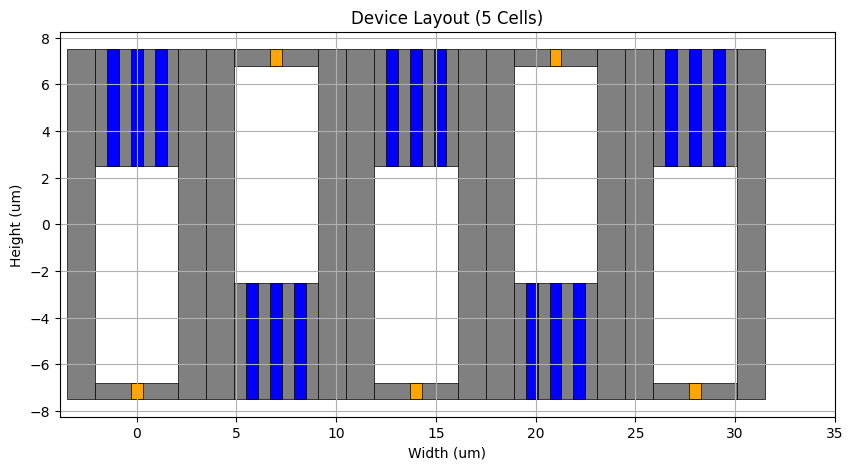

Ground Capacitance = 9.730545999999999 (fF)
Large Junction Capacitance = 4.1908933333333325 (fF)
Cirtical Current: 1.7999999999999998 (uA)


In [23]:
### Cell and TWPA instantiation ###

# Units of um
cell_layout = UnitCellLayout(cell_height=15, cell_width=7, I0_ratio=0.14, bottom_margin=0.6, jj_width=0.6, jj_height=5,
                            chip_separation=300, jj_seperation=3, relative_permitivity=1, J0 = 0.6e-6)

row_length = 40
cell_layout.draw_row(N=int(row_length/cell_layout.cell_width))

Cg = cell_layout.calculate_Cg()
Cj = cell_layout.calculate_Cj()
I0 = cell_layout.calculate_I0()

# impedance = np.sqrt()

print(f"Ground Capacitance = {Cg*1e15} (fF)")
print(f"Large Junction Capacitance = {Cj*1e15} (fF)")
print(f"Cirtical Current: {I0*1e6} (uA)")

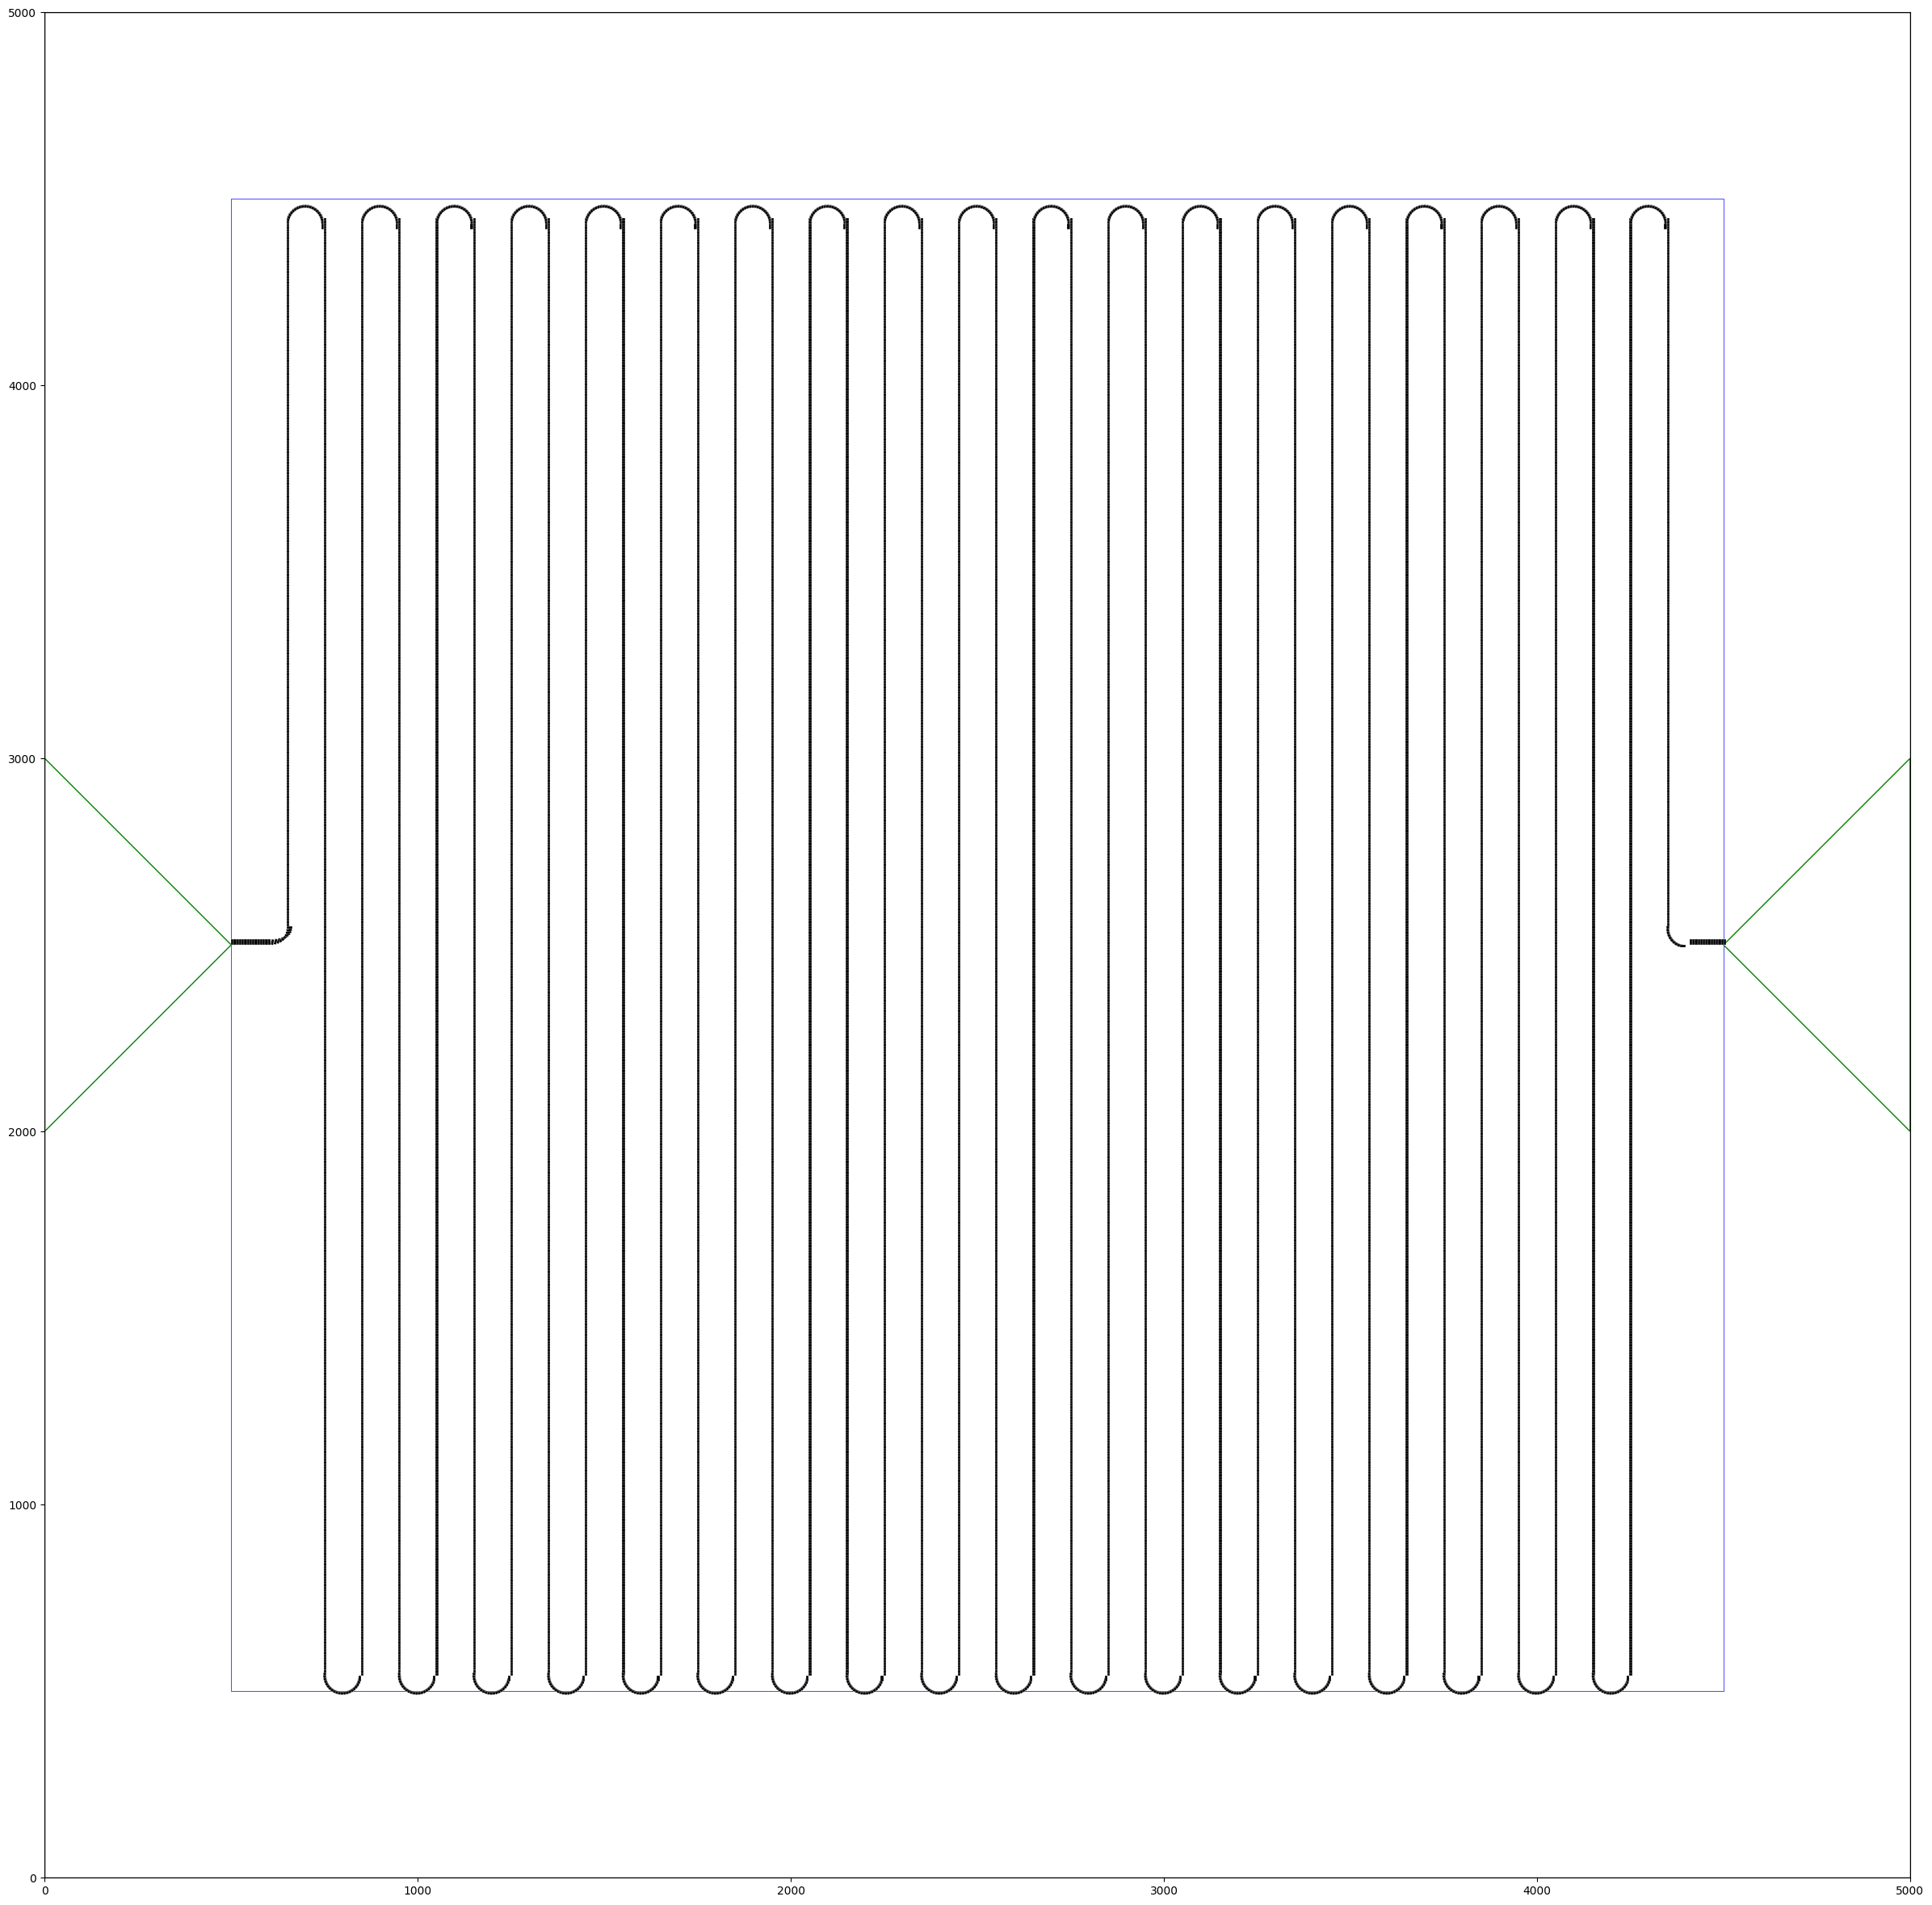

Total Devices: 20593


In [ ]:
geometry = ReverseKerrTWPAGeometry(chip_height=5000, chip_width=5000, margin=500, launchpads=[(0, 2500), (5000, 2500)],
                                   line_gap=100, line_width=cell_layout.cell_height, cell_width=cell_layout.cell_width, 
                                   delay_length = 100, num_paths=36)
geometry.plot_geometry()
print(f"Total Devices: {geometry.total_devices}")

In [ ]:
### Final TWPA parameters ###
sim_params = {
    'pump_frequency': 8, #GHz
    'incident_pump_amplitude': 1.6,
    'loss_tangent': -1e-6,
    'number_of_loops': geometry.total_devices,
    'size_of_one_loop': cell_layout.cell_width*1e-6, #m
    'I0': I0, #uA
    'I0_ratio': cell_layout.I0_ratio, 
    'C_g': Cg, #F
    'C_J': Cj #F
}

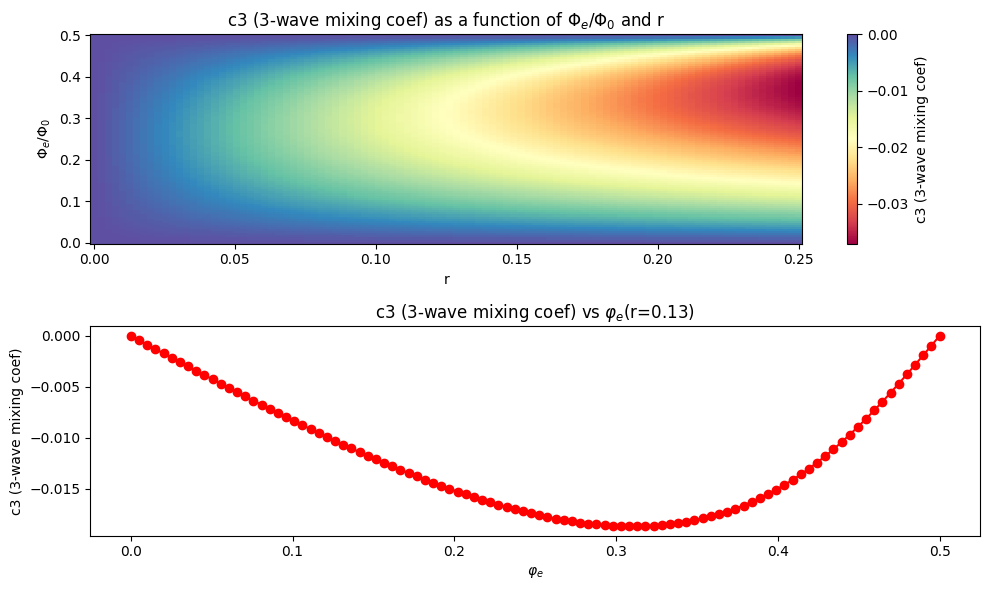

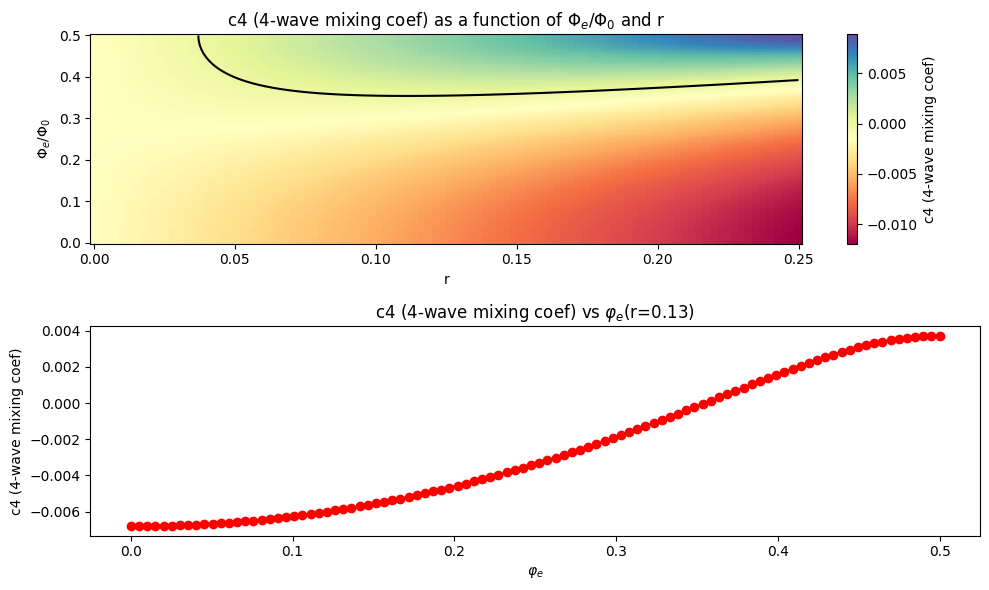

In [ ]:
### SNAIL current simulation ###
snail = SNAIL(Cg, sim_params["I0"], 3)

# Define phi_e and r values
phis = np.linspace(0, 0.5, 100)
rs = np.linspace(0, 0.25, 100)

# Plot heatmaps
snail.plot_heatmap(phis, rs, snail.c3, 'c3 (3-wave mixing coef)')

snail.plot_heatmap(phis, rs, snail.c4, 'c4 (4-wave mixing coef)')

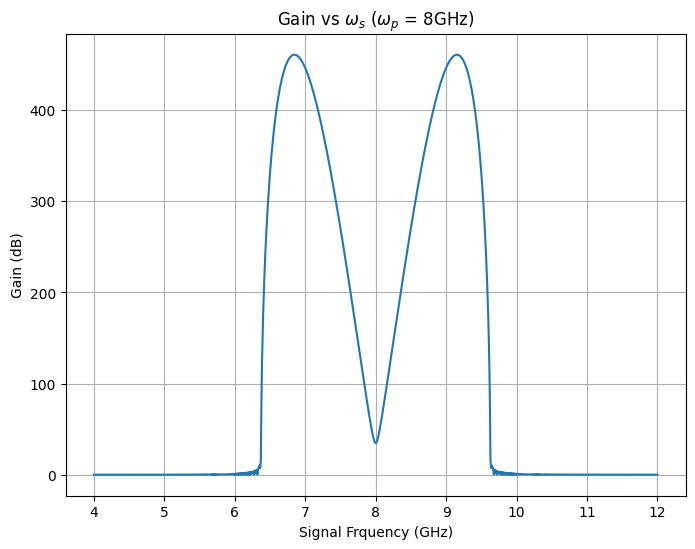

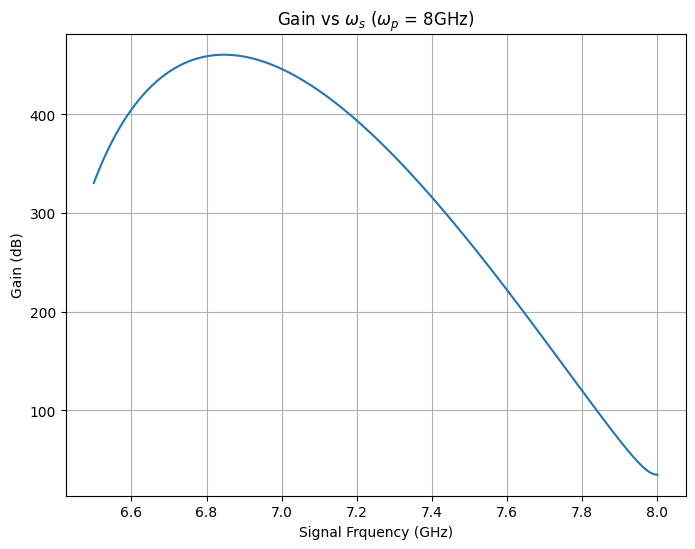

In [ ]:
### Gain simulation and parameter space plots ###
# Create a copy of sim with original parameters
sim_original = copy.deepcopy(dispersion_in_JJ_metamaterial())

for key, value in sim_params.items():
    setattr(sim_original, key, value)
sim_original.calculate_loop_parameters()

omega_s_range = np.linspace(4, 12, 1000)
gain_values = sim_original.gain_vs_freq(omega_s_range)

plt.figure(figsize=(8, 6))
plt.plot(omega_s_range, gain_values)
plt.xlabel('Signal Frquency (GHz)')
plt.ylabel(r'Gain (dB)')
plt.title(r'Gain vs $\omega_s$ ($\omega_p$ = 8GHz)')
plt.grid(True)
plt.show()


focal_freq_range = np.linspace(6.5, 8, 1000)
focal_gain_values = sim_original.gain_vs_freq(focal_freq_range)

plt.figure(figsize=(8, 6))
plt.plot(focal_freq_range, focal_gain_values)
plt.xlabel('Signal Frquency (GHz)')
plt.ylabel(r'Gain (dB)')
plt.title(r'Gain vs $\omega_s$ ($\omega_p$ = 8GHz)')
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/site-packages/scipy/linalg/_matfuncs.py:314: RuntimeWarning: overflow encountered in cosh
  coshMu = np.cosh(mu)
/usr/local/lib/python3.11/site-packages/scipy/linalg/_matfuncs.py:317: RuntimeWarning: overflow encountered in sinh
  sinchMu[mask] = np.sinh(mu[mask]) / mu[mask]
/usr/local/lib/python3.11/site-packages/scipy/linalg/_matfuncs.py:317: RuntimeWarning: invalid value encountered in divide
  sinchMu[mask] = np.sinh(mu[mask]) / mu[mask]
/var/folders/8g/g48bxxwn3139k68mrwrpq2xw0000gn/T/ipykernel_5299/728655511.py:111: RuntimeWarning: invalid value encountered in sqrt
  k_i = w_i/(w_0*np.sqrt(1-(w_i/w_J)**2))
/var/folders/8g/g48bxxwn3139k68mrwrpq2xw0000gn/T/ipykernel_5299/728655511.py:128: RuntimeWarning: invalid value encountered in divide
  Phi21 = -1j*eta_i*k_s/(k_i*2)
/usr/local/lib/python3.11/site-packages/numpy/lib/scimath.py:135: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):
/var/folders/8g/g48bxxwn3139k68mrwrpq2xw0

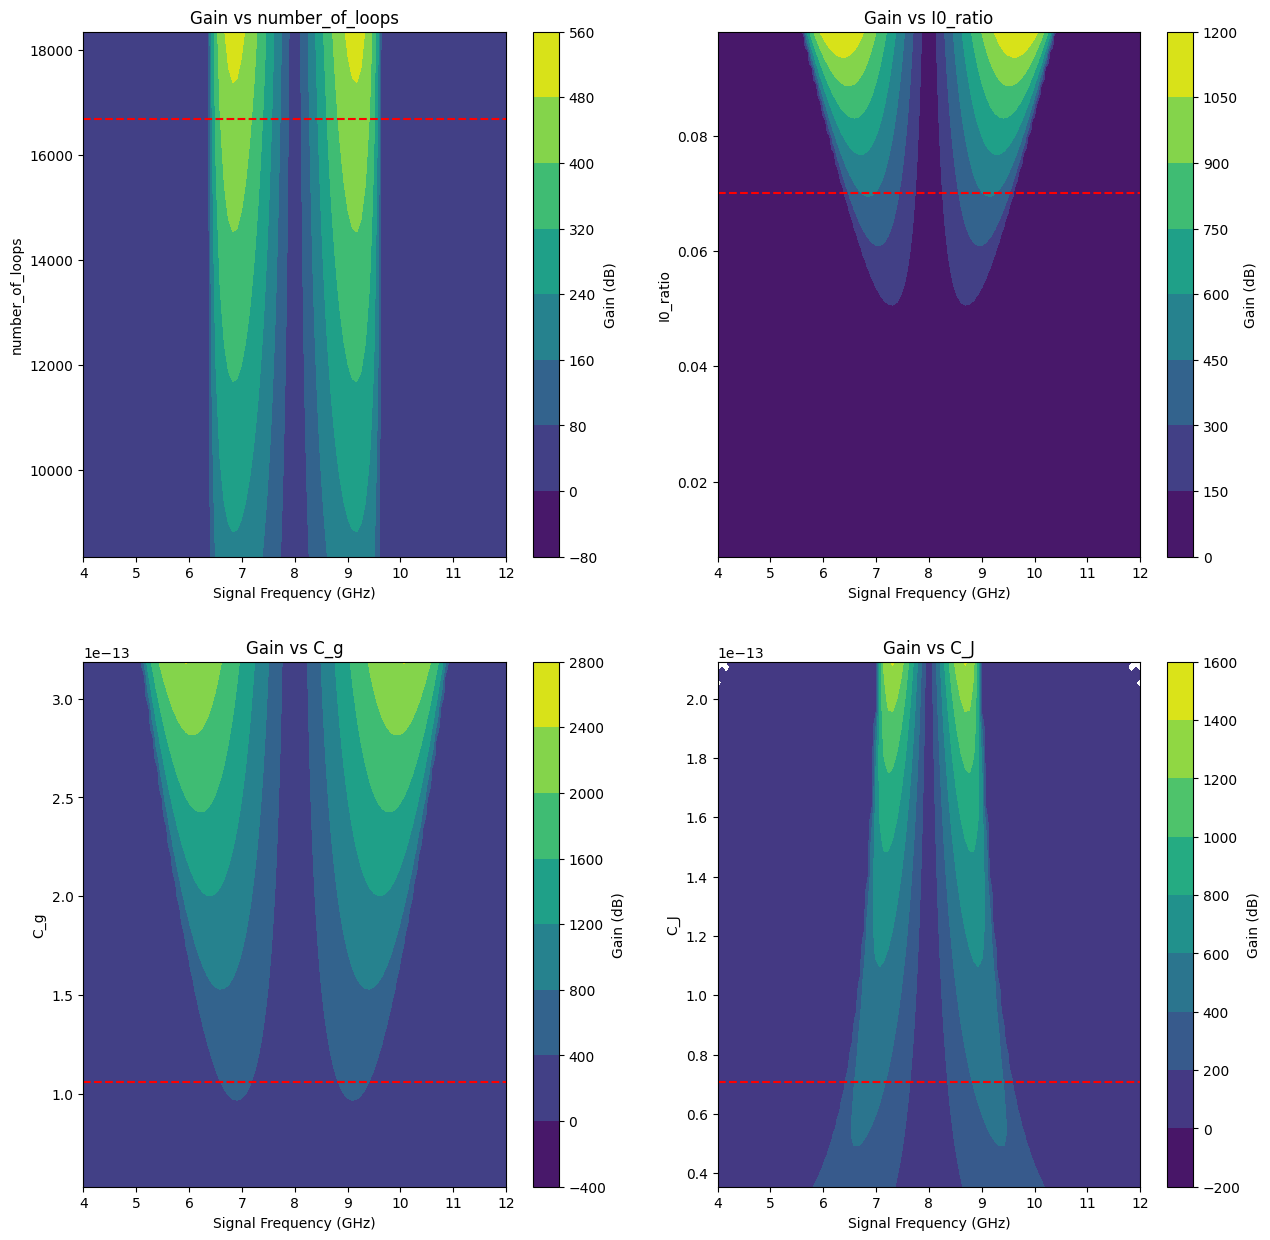

In [ ]:
# Define the parameter ranges to explore
pump_frequencies = [8]  # Keep pump frequency constant
number_of_loops_values = np.linspace(0.5*sim_params['number_of_loops'], 1.1*sim_params['number_of_loops'], 100)
I0_ratio_values = np.linspace(0.1*sim_params['I0_ratio'], 1.4*sim_params['I0_ratio'], 100)
C_J_values = np.linspace(0.5*sim_params['C_J'], 3*sim_params['C_J'], 100)
C_g_values = np.linspace(0.5*sim_params['C_g'], 3*sim_params['C_g'], 100)

# Create a subplot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.2)

# Vary different parameters and plot gain maps
for ax, param_values, param_name in zip(axes.flatten(),
                                       [number_of_loops_values, I0_ratio_values, C_g_values, C_J_values],
                                       ['number_of_loops', 'I0_ratio', 'C_g', 'C_J']):
    gains = []
    for param_value in param_values:
        # Create a copy of sim_original for each iteration
        sim_copy = copy.deepcopy(sim_original)

        # Set the parameter value in the simulation copy
        setattr(sim_copy, param_name, param_value)
        sim_copy.calculate_loop_parameters()  # Recalculate loop parameters if needed
        omega_s_range = np.linspace(4, 12, 100)
        gain_values = sim_copy.gain_vs_freq(omega_s_range)
        gains.append(gain_values)

    # Create a contour plot for the gain map
    X, Y = np.meshgrid(omega_s_range, param_values)
    gains = np.array(gains)
    contour = ax.contourf(X, Y, gains, cmap='viridis')
    ax.set_xlabel('Signal Frequency (GHz)')
    ax.set_ylabel(param_name)
    ax.set_title(f'Gain vs {param_name}')
    
    # Add horizontal line at value used in simulation
    ax.axhline(sim_params[param_name], color='red', linestyle='--', label='Simulation Value')
    
    # Add colorbar legend
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label('Gain (dB)')

# Show the plots
plt.show()

In [ ]:
# UTILS

# Takes goal junction capacitance (F), outputs required seperation
def calc_JJ_distance(Cj):
    return e0 * 10 * (cell_layout.jj_height) * 1e-6 * (cell_layout.jj_width) * 1e-6 / Cj

print(f"JJ must have gap of {calc_JJ_distance(Cj)*1e9} nm")

JJ must have gap of 2.9999999999999996 nm
